In [1]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from datetime import datetime
import os

In [2]:
def save_simulation_snapshots(filename: str, dimensions: tuple[int, ...],  
                            output_path: str, iterations: list[int] = [0, 6, 12, 19]) -> None:
    """Save simulation snapshots at specified iterations as a 2x2 figure.
    
    Args:
        filename: Path to CSV file containing simulation data
        dimensions: Tuple of dimensions for reshaping the data
        iterations: List of iterations to display (default: [0, 15, 30, 50])
        output_path: Optional path to save the figure
    """
    df = pd.read_csv(filename, header=None)
    if max(iterations) >= len(df):
        raise ValueError(f"Max iteration {max(iterations)} exceeds data length {len(df)}")

    
    # Get global min and max for consistent colorbar scale
    all_frames = [np.array(df.iloc[i]).reshape(dimensions, order='F') for i in iterations]
    vmin = min(frame.min() for frame in all_frames)
    vmax = max(frame.max() for frame in all_frames)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Simulation Snapshots', fontsize=16)
    
    for idx, iter_num in enumerate(iterations):
        ax = axes[idx // 2, idx % 2]
        frame_data = np.array(df.iloc[iter_num]).reshape(dimensions, order='F')
        im = ax.imshow(frame_data.T, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
        # Create a more compact colorbar
        cbar = plt.colorbar(im, ax=ax, label='Density', fraction=0.046, pad=0.04)
        ax.set_title(f't = {iter_num}', pad=10)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Snapshots saved to {output_path}")

In [3]:
def animate_density_evolution(dimensions: tuple[int, int], filename: str, interval: int = 100, repeat: bool = False) -> FuncAnimation:
    # Read the CSV file
    df = pd.read_csv(filename, header=None)
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    img = ax.imshow(np.zeros(dimensions).T, cmap='viridis', origin='lower', animated=True)
    plt.colorbar(img)
    
    ax.set_title('Density Evolution')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    def init():
        img.set_array(np.zeros(dimensions).T)
        return [img]
    
    def update(frame):
        # Reshape the flattened data back to 2D and transpose
        current_density = df.iloc[frame].values.reshape(dimensions, order='F').T
        img.set_array(current_density)
        img.set_clim(vmin=df.values.min(), vmax=df.values.max())
        return [img]
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=len(df),
                        init_func=init, blit=True,
                        interval=interval, repeat=repeat)
    
    return anim

In [3]:
def get_ring_initial_distribution(sites: tuple[int, int], 
                              cylinder_radius_outer: float,
                              cylinder_radius_inner: float,
                              background_density: float = 0.1,
                              ring_density: float = 0.4) -> NDArray[np.float64]:
    """
    Create a ring-shaped initial distribution.
    
    Args:
        sites: Tuple of (height, width) for the grid
        cylinder_radius_outer: Outer radius of the ring
        cylinder_radius_inner: Inner radius of the ring
        background_density: Density value outside the ring
        ring_density: Density value in the ring region
        
    Returns:
        density: Initial density distribution with a ring pattern
    """
    # Initialize density array with background value
    density = np.full(sites, background_density)
    
    # Create coordinate grid
    x = np.arange(sites[0])
    y = np.arange(sites[1])
    X, Y = np.meshgrid(x, y)
    
    # Calculate center points
    center_x = sites[0] / 2
    center_y = sites[1] / 2
    
    # Create ring mask
    distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    ring_mask = ((distance_from_center < cylinder_radius_outer) & 
                 (distance_from_center > cylinder_radius_inner)).T
    
    # Set ring density
    density[ring_mask] = ring_density
    
    return density

def get_shear_velocity_field(sites: tuple[int, int], u_magnitude: float = 0.2, v_magnitude: float = 0.1) -> NDArray[np.float64]:
    """
    Create a shear velocity field with opposite horizontal velocities in upper and lower halves.
    
    Args:
        sites: Tuple of (width, height) for the grid
        u_magnitude: Magnitude of horizontal velocity
        v_magnitude: Magnitude of vertical velocity
        
    Returns:
        velocity_field: Array of shape (2, height, width) containing the velocity components
    """
    
    # Initialize velocity components with proper orientation
    u = np.full(sites, u_magnitude)
    v = np.full(sites, v_magnitude)
    
    
    u[:, int(sites[1] / 2):] = -u_magnitude
    
    # Stack into velocity field (u=horizontal velocity, v=vertical velocity)
    velocity_field = np.stack([u, v])
    
    return velocity_field

In [ ]:
# Create new sites configuration
sites_ring = (32, 16)
links = [[0,0], [-1, 0], [1,0], [0, -1], [0, 1], [-1, -1], [-1, 1], [1, -1], [1, 1]]
weights = [4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36]
speed_of_sound = 1/np.sqrt(3)
# Define ring parameters
cylinder_radius_outer = 4
cylinder_radius_inner = 2
background_density = 0.1
ring_density = 0.9

# Create ring-shaped initial distribution
initial_dist_ring = get_ring_initial_distribution(sites_ring, cylinder_radius_outer, cylinder_radius_inner, background_density, ring_density)
# Create shear velocity field
shear_velocity_field = get_shear_velocity_field(sites_ring, u_magnitude=0.2, v_magnitude=0.1)

# Update configuration for simulation
config_ring = [(25, shear_velocity_field, links, weights, speed_of_sound)]

In [5]:
import importlib
import qlbmlib
importlib.reload(qlbmlib)

<module 'qlbmlib' from 'd:\\Data\\Codes\\Quantum\\Research\\qlbmlib.py'>

In [7]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
dirname = f"experiments/2DQ9Shear_{timestamp}"
os.mkdir(dirname)

classical_csv = f"{dirname}/classical.csv"
quantum_csv = f"{dirname}/quantum.csv"

classical_fig =f"{dirname}/classical.png"
quantum_fig = f"{dirname}/quantum.png"

rmse_plot = f"{dirname}/rmse_plot.png"

_ = qlbmlib.simulate_flow_classical(initial_dist_ring, config_ring, classical_csv)
_ = qlbmlib.simulate_flow(initial_dist_ring, config_ring, quantum_csv, True)

Classical simulation: iterations 0-40/40
Classical Iteration 1/40
Classical Iteration 2/40
Classical Iteration 3/40
Classical Iteration 4/40
Classical Iteration 5/40
Classical Iteration 6/40
Classical Iteration 7/40
Classical Iteration 8/40
Classical Iteration 9/40
Classical Iteration 10/40
Classical Iteration 11/40
Classical Iteration 12/40
Classical Iteration 13/40
Classical Iteration 14/40
Classical Iteration 15/40
Classical Iteration 16/40
Classical Iteration 17/40
Classical Iteration 18/40
Classical Iteration 19/40
Classical Iteration 20/40
Classical Iteration 21/40
Classical Iteration 22/40
Classical Iteration 23/40
Classical Iteration 24/40
Classical Iteration 25/40
Classical Iteration 26/40
Classical Iteration 27/40
Classical Iteration 28/40
Classical Iteration 29/40
Classical Iteration 30/40
Classical Iteration 31/40
Classical Iteration 32/40
Classical Iteration 33/40
Classical Iteration 34/40
Classical Iteration 35/40
Classical Iteration 36/40
Classical Iteration 37/40
Classi

In [8]:
save_simulation_snapshots(classical_csv, sites_ring, classical_fig, [0, 15, 30, 40])
save_simulation_snapshots(quantum_csv, sites_ring, quantum_fig, [0, 15, 30, 40])
qlbmlib.save_rmse_comparison(classical_csv, quantum_csv, sites_ring, rmse_plot)

Snapshots saved to experiments/2DQ9Shear_20250607_141322/classical.png
Snapshots saved to experiments/2DQ9Shear_20250607_141322/quantum.png
RMSE comparison saved to experiments/2DQ9Shear_20250607_141322/rmse_plot.png


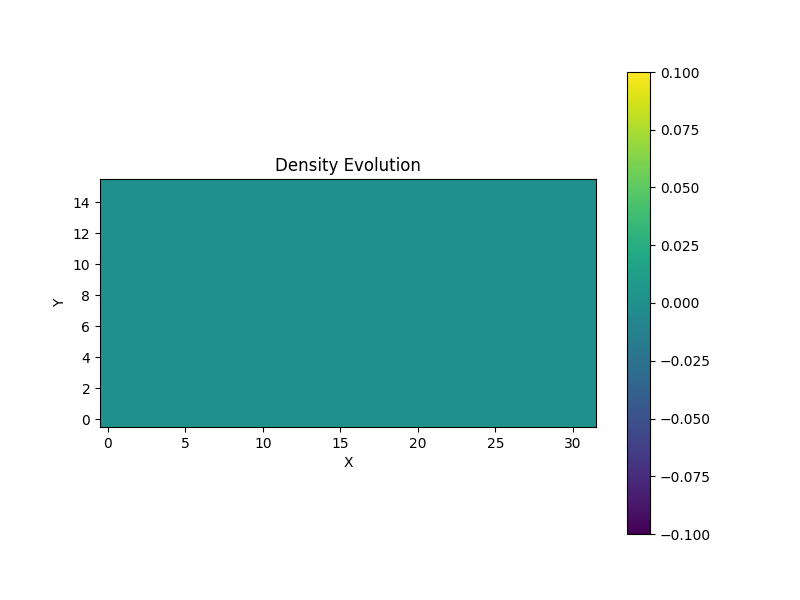

In [9]:
%matplotlib widget

anim = animate_density_evolution(sites_ring, classical_csv)